In [711]:
import numpy as np
import torch
import torch.nn as tnn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.datasets import fetch_openml

from matplotlib import pyplot as plt

In [712]:
#device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [713]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False)
y = y.astype(int)

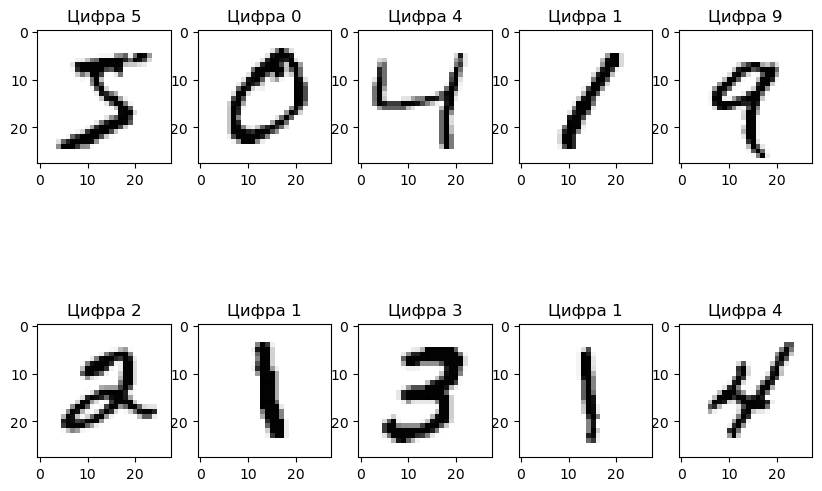

In [714]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % y[i])

In [715]:
def perturb_image(xs, image):
    # If this function is passed just one perturbation vector,
    # pack it in a list to keep the computation the same
    if xs.ndim < 2:
        xs = np.array([xs])

    # Copy the image n == len(xs) times so that we can
    # create n new perturbed images
    tile = [len(xs)] + [1]*(xs.ndim+1)
    imgs = np.tile(image, tile)

    # Make sure to floor the members of xs as int types
    xs = xs.astype(int)

    for x, image in zip(xs, imgs):
        # Split x into an array of 5-tuples (perturbation pixels)
        # i.e., [[x,y,r,g,b], ...]
        pixels = np.split(x, len(x) // 5)
        for pixel in pixels:
            # At each pixel's x,y position, assign its rgb value
            x_pos, y_pos, *rgb = pixel
            image[x_pos, y_pos] = rgb

    return imgs

In [716]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
train_dataset = TensorDataset(torch.from_numpy(X_train).float(),
                              torch.from_numpy(y_train).long())
train_loader = DataLoader(train_dataset, batch_size=64)

test_dataset = TensorDataset(torch.from_numpy(X_test).float(),
                              torch.from_numpy(y_test).long())
test_loader = DataLoader(test_dataset, batch_size=64)

In [717]:
pixel = np.array([16, 16, 255, 255, 0]) # pixel = x,y,r,g,b
image_perturbed = perturb_image(pixel, test_dataset)

plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(image_perturbed[i].reshape(28, 28), cmap='Greys')

IndexError: index 16 is out of bounds for axis 0 with size 1

In [ ]:
def evaluate_model():
    global model
    model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in test_loader:
            out = model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()
    loss_current = criterion(out, lbls)
    return correct_out / total_out, loss_current
    # print("Test accuracy:", 100 * correct_out / total, "%")

In [ ]:
def train_accuracy():
    global model
    model.eval()
    with torch.no_grad():
        correct_out = 0
        total_out = 0
        for pics, lbls in train_loader:
            out = model(pics)
            pred = torch.argmax(out, dim=1)
            total_out += lbls.shape[0]
            correct_out += (pred == lbls).sum().item()
    return correct_out / total_out

In [ ]:
model = tnn.Sequential(tnn.Linear(in_features=X.shape[1], out_features=512),
                      tnn.ReLU(),
                      tnn.Linear(512, 128),
                      tnn.ReLU(),
                      tnn.Linear(128, 10)
                    )

In [ ]:
criterion = tnn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
EPOCH_NUM = 100

train_losses = []
test_losses = []
test_accuracies = []
train_accuracies = []

for epoch in range(EPOCH_NUM):
    current_loss = 0
    current_accuracy = 0
    for i, (images, labels) in enumerate(train_loader):
        outputs = model(images)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        current_loss = loss.item()
        if (i+1)%200 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss {:.4f}'.format(epoch+1, EPOCH_NUM, i+1, len(train_loader), current_loss))


    train_accuracies.append(train_accuracy())
    train_losses.append(current_loss)

    test_accuracies.append(evaluate_model()[0])
    test_losses.append(evaluate_model()[1])

In [ ]:
epochs = range(1, EPOCH_NUM+1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_losses)
plt.plot(epochs, test_losses)
plt.legend(["Train Loss", "Test Loss"])
plt.show()

train_losses[90]

In [ ]:
epochs = range(1, EPOCH_NUM+1)
plt.figure(figsize=(10, 7))
plt.plot(epochs, train_accuracies)
plt.plot(epochs, test_accuracies)
plt.legend(["Train Accuracy", "Test Accuracy"])
plt.show()

In [ ]:
test_accuracies, train_accuracies

In [ ]:
import cv2
import numpy as np

data = []
classes = [2, 3, 6, 8, 9, 1, 0, 4, 7, 5]
for i in range(10):
    img = cv2.imread("my_dataset/"+str(i+1)+".png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sharp_filter = np.array([[-1, 0, -1],
                             [0, 7, 0],
                             [-1, 0, -1]])
    img = cv2.filter2D(img, ddepth=-1, kernel=sharp_filter)

    img = cv2.bitwise_not(img)
    img = img.astype('float32')
    data.append(img)

data = np.reshape(data,(len(data), 28*28))
# data = np.array(data)
classes = np.array(classes)

print(data.shape)

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("Цифра %d" % classes[i])

In [ ]:
experiment_dataset = TensorDataset(torch.from_numpy(data).float(),
                              torch.from_numpy(classes).long())
experiment_loader = DataLoader(experiment_dataset, batch_size=64)

In [ ]:
model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in experiment_loader:
        outputs = model(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.shape[0]
        correct += (predicted == labels).sum().item()
    print("Test accuracy:",
          100*correct/total, "%")

In [ ]:
plt.figure(figsize=(10, 7))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(data[i].reshape(28, 28), cmap='Greys')
    plt.title("%d, pred: %d" % (classes[i], predicted[i]))